# PopHealth Observatory
## Population health & nutrition analytics using NHANES survey microdata

This notebook demonstrates how to use the NHANESExplorer (now part of the PopHealth Observatory package) to download, process, and analyze data from the National Health and Nutrition Examination Survey (NHANES). The observatory provides tools to analyze health metrics across demographic groups and survey cycles.

## 1. Import Required Libraries

In [33]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from typing import Dict, List, Optional, Tuple
import ipywidgets as widgets
from ipywidgets import interact, fixed
import warnings
warnings.filterwarnings('ignore')

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

## 2. Observatory Class Import

We'll import the NHANESExplorer class from the PopHealth Observatory package (`pophealth_observatory`).

In [34]:
# Import the NHANESExplorer class from the PopHealth Observatory package
from pophealth_observatory import NHANESExplorer

# Initialize the explorer
explorer = NHANESExplorer()

# Display the available survey cycles and components
print("Available NHANES survey cycles:")
print(explorer.available_cycles)
print("\nAvailable data components:")
for name, code in explorer.components.items():
    print(f"  - {name}: {code}")

Available NHANES survey cycles:
['2021-2022', '2019-2020', '2017-2018', '2015-2016', '2013-2014', '2011-2012', '2009-2010']

Available data components:
  - demographics: DEMO
  - body_measures: BMX
  - blood_pressure: BPX
  - cholesterol: TCHOL
  - diabetes: GLU
  - dietary: DR1TOT
  - physical_activity: PAQ
  - smoking: SMQ
  - alcohol: ALQ


## 3. Data Acquisition

Let's download some key NHANES data components for the most recent survey cycle (2017-2018).

In [35]:
# Choose a valid cycle (ensure it exists in explorer.cycle_suffix_map)
cycle_debug = '2017-2018'  # try '2021-2022' or others from explorer.available_cycles
component_code = explorer.components['demographics']

# 1. Derive letter suffix & candidate URLs (mirrors updated logic)
letter = explorer.cycle_suffix_map.get(cycle_debug, 'UNKNOWN') if hasattr(explorer, 'cycle_suffix_map') else 'NA'
print('Cycle:', cycle_debug, '| Letter suffix:', letter)

base_url = getattr(explorer, 'base_url', 'N/A')
alt_base = getattr(explorer, 'alt_base_url', 'N/A')
primary = f"{base_url}/{cycle_debug}/{component_code}_{letter}.XPT"
alt1 = f"{alt_base}/{cycle_debug.split('-')[0]}/DataFiles/{component_code}_{letter}.xpt"
alt2 = f"{alt_base}/{cycle_debug.split('-')[0]}/DataFiles/{component_code}_{letter}.XPT"
CandidateURLs = [primary, alt1, alt2]
print('\nCandidate URLs (in order):')
for u in CandidateURLs:
    print('  ', u)

# 2. Try fetching each URL, report HTTP status
import requests, io
raw_bytes = None
for idx, u in enumerate(CandidateURLs, 1):
    try:
        resp = requests.get(u, timeout=20)
        print(f"Attempt {idx}: {u} -> status {resp.status_code}")
        if resp.status_code == 200:
            raw_bytes = resp.content
            print('  -> Success, size:', len(raw_bytes), 'bytes')
            break
    except Exception as e:
        print(f"  -> Error: {e}")

if raw_bytes is None:
    print('\nNo successful download; stopping here.')
else:
    # 3. Read SAS transport file
    try:
        demo_raw = pd.read_sas(io.BytesIO(raw_bytes), format='xport')
        print('\nRaw demographics shape:', demo_raw.shape)
        print('Columns sample:', list(demo_raw.columns[:20]))
    except Exception as e:
        print('Failed to parse XPT:', e)
        demo_raw = pd.DataFrame()

    # 4. Apply variable selection + renaming (same mapping as in method)
    demo_vars = {
        'SEQN': 'participant_id',
        'RIAGENDR': 'gender',
        'RIDAGEYR': 'age_years',
        'RIDRETH3': 'race_ethnicity',
        'DMDEDUC2': 'education',
        'INDFMPIR': 'poverty_ratio',
        'WTMEC2YR': 'exam_weight',
    }
    available = [c for c in demo_vars if c in demo_raw.columns]
    print('\nVariables present from mapping:', available)
    demo_clean = demo_raw[available].copy() if available else pd.DataFrame()
    if not demo_clean.empty:
        demo_clean = demo_clean.rename(columns={k:v for k,v in demo_vars.items() if k in available})

        # 5. Add decoded labels
        if 'gender' in demo_clean.columns:
            demo_clean['gender_label'] = demo_clean['gender'].map({1:'Male',2:'Female'})
        if 'race_ethnicity' in demo_clean.columns:
            race_labels = {1:'Mexican American',2:'Other Hispanic',3:'Non-Hispanic White',4:'Non-Hispanic Black',6:'Non-Hispanic Asian',7:'Other/Multi-racial'}
            demo_clean['race_ethnicity_label'] = demo_clean['race_ethnicity'].map(race_labels)

        print('\nCleaned demographics shape:', demo_clean.shape)
        display(demo_clean.head())
    else:
        print('No mapped variables found in downloaded file.')

Cycle: 2017-2018 | Letter suffix: J

Candidate URLs (in order):
   https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT
   https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
   https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.XPT
Attempt 1: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT -> status 200
  -> Success, size: 20905 bytes
Failed to parse XPT: Header record is not an XPORT file.

Variables present from mapping: []
No mapped variables found in downloaded file.


### Debug: Deconstruct `get_demographics_data()`
The following cell manually reproduces each internal step of `get_demographics_data` so you can inspect URL construction, HTTP responses, raw columns, and recoding. If you are getting empty data, likely the cycle string does not match a known mapping (e.g. use `2021-2022` not `2021-2023`).

In [36]:
# Set the survey cycle
# NOTE: 2021-2022 data has limited availability. Use 2017-2018 for complete datasets.
cycle = '2017-2018'

# Download demographics data
print("Available cycles:", explorer.available_cycles)
print(f"\nDownloading data for cycle: {cycle}")
demo_df = explorer.get_demographics_data(cycle)

# Display the first few rows
print(f"Demographics data shape: {demo_df.shape}")
demo_df.head()


Available cycles: ['2021-2022', '2019-2020', '2017-2018', '2015-2016', '2013-2014', '2011-2012', '2009-2010']

Trying demographics URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
✓ Success loading demographics from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
Demographics data shape: (9254, 12)


,participant_id,gender,age_years,race_ethnicity,education,poverty_ratio,exam_weight,interview_weight,psu,strata,gender_label,race_ethnicity_label
0,93703.0,2.0,2.0,6.0,NaN,5.00,8539.731348,9246.491865,2.0,145.0,Female,Non-Hispanic Asian
1,93704.0,1.0,2.0,3.0,NaN,5.00,42566.614750,37338.768343,1.0,143.0,Male,Non-Hispanic White
2,93705.0,2.0,66.0,4.0,2.0,0.82,8338.419786,8614.571172,2.0,145.0,Female,Non-Hispanic Black
3,93706.0,1.0,18.0,6.0,NaN,NaN,8723.439814,8548.632619,2.0,134.0,Male,Non-Hispanic Asian
4,93707.0,1.0,13.0,7.0,NaN,1.88,7064.609730,6769.344567,1.0,138.0,Male,Other/Multi-racial


In [37]:
# Download body measurements data
body_df = explorer.get_body_measures(cycle)

# Display the first few rows
print(f"Body measurements data shape: {body_df.shape}")
body_df.head()

Trying BMX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BMX_J.xpt
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BMX_J.xpt
Body measurements data shape: (8704, 6)


,participant_id,weight_kg,height_cm,bmi,waist_cm,bmi_category
0,93703.0,13.7,88.6,17.5,48.2,Underweight
1,93704.0,13.9,94.2,15.7,50.0,Underweight
2,93705.0,79.5,158.3,31.7,101.8,Obese
3,93706.0,66.3,175.7,21.5,79.3,Normal
4,93707.0,45.4,158.4,18.1,64.1,Underweight


In [38]:
# Download blood pressure data
bp_df = explorer.get_blood_pressure(cycle)

# Display the first few rows
print(f"Blood pressure data shape: {bp_df.shape}")
bp_df.head()

Trying BPX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BPX_J.xpt
✓ Success loading BPX from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BPX_J.xpt
Blood pressure data shape: (8704, 10)


,participant_id,systolic_bp_1,diastolic_bp_1,systolic_bp_2,diastolic_bp_2,systolic_bp_3,diastolic_bp_3,avg_systolic,avg_diastolic,bp_category
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
1,93704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
2,93705.0,NaN,NaN,NaN,NaN,202.0,62.0,202.000000,62.000000,Stage 2 Hypertension
3,93706.0,112.0,74.0,114.0,70.0,108.0,76.0,111.333333,73.333333,Normal
4,93707.0,128.0,38.0,128.0,46.0,128.0,58.0,128.000000,47.333333,Elevated


## 4. Data Processing

Now let's create a merged dataset that combines demographics, body measurements, and blood pressure data.

In [39]:
# Create a merged dataset with demographics, body measurements, and blood pressure
merged_df = explorer.create_merged_dataset(cycle)

# Display column names and data types
print(f"Merged dataset shape: {merged_df.shape}")
merged_df.dtypes

Creating merged dataset for 2017-2018...
Trying demographics URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
✓ Success loading demographics from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
Merged dataset created with 9254 participants and 26 variables
Merged dataset shape: (9254, 26)


participant_id           float64
gender                   float64
age_years                float64
race_ethnicity           float64
education                float64
poverty_ratio            float64
exam_weight              float64
interview_weight         float64
psu                      float64
strata                   float64
gender_label              object
race_ethnicity_label      object
weight_kg                float64
height_cm                float64
bmi                      float64
waist_cm                 float64
bmi_category            category
systolic_bp_1            float64
diastolic_bp_1           float64
systolic_bp_2            float64
diastolic_bp_2           float64
systolic_bp_3            float64
diastolic_bp_3           float64
avg_systolic             float64
avg_diastolic            float64
bp_category               object
dtype: object

In [40]:
# Display the first few rows of the merged dataset
merged_df.head()

,participant_id,gender,age_years,race_ethnicity,education,poverty_ratio,exam_weight,interview_weight,psu,strata,...,bmi_category,systolic_bp_1,diastolic_bp_1,systolic_bp_2,diastolic_bp_2,systolic_bp_3,diastolic_bp_3,avg_systolic,avg_diastolic,bp_category
0,93703.0,2.0,2.0,6.0,NaN,5.00,8539.731348,9246.491865,2.0,145.0,...,Underweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
1,93704.0,1.0,2.0,3.0,NaN,5.00,42566.614750,37338.768343,1.0,143.0,...,Underweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
2,93705.0,2.0,66.0,4.0,2.0,0.82,8338.419786,8614.571172,2.0,145.0,...,Obese,NaN,NaN,NaN,NaN,202.0,62.0,202.000000,62.000000,Stage 2 Hypertension
3,93706.0,1.0,18.0,6.0,NaN,NaN,8723.439814,8548.632619,2.0,134.0,...,Normal,112.0,74.0,114.0,70.0,108.0,76.0,111.333333,73.333333,Normal
4,93707.0,1.0,13.0,7.0,NaN,1.88,7064.609730,6769.344567,1.0,138.0,...,Underweight,128.0,38.0,128.0,46.0,128.0,58.0,128.000000,47.333333,Elevated


## 5. Data Analysis

Let's perform some basic analyses on the merged dataset.

In [41]:
# Generate a summary report
summary_report = explorer.generate_summary_report(merged_df)
print(summary_report)

PopHealth Observatory Summary Report
Total Participants: 9,254
Total Variables: 26

Age Distribution:
  Mean age: 34.3 years
  Age range: 0 - 80 years

Gender Distribution:
  Female: 4,697 (50.8%)
  Male: 4,557 (49.2%)

Race/Ethnicity Distribution:
  Non-Hispanic White: 3,150 (34.0%)
  Non-Hispanic Black: 2,115 (22.9%)
  Mexican American: 1,367 (14.8%)
  Non-Hispanic Asian: 1,168 (12.6%)
  Other Hispanic: 820 (8.9%)
  Other/Multi-racial: 634 (6.9%)

Health Metrics Summary:
  bmi:
    Mean: 26.58
    Range: 12.30 - 86.20
    Missing: 1,249 (13.5%)
  avg_systolic:
    Mean: 121.69
    Range: 72.67 - 238.00
    Missing: 2,540 (27.4%)
  avg_diastolic:
    Mean: 68.33
    Range: 0.00 - 135.33
    Missing: 2,540 (27.4%)
  weight_kg:
    Mean: 65.14
    Range: 3.20 - 242.60
    Missing: 674 (7.3%)
  height_cm:
    Mean: 156.59
    Range: 78.30 - 197.70
    Missing: 1,238 (13.4%)



In [42]:
# Analyze BMI by race/ethnicity
if 'bmi' in merged_df.columns and 'race_ethnicity_label' in merged_df.columns:
    bmi_by_race = explorer.analyze_by_demographics(merged_df, 'bmi', 'race_ethnicity_label')
    print("BMI Statistics by Race/Ethnicity:")
    display(bmi_by_race)

BMI Statistics by Race/Ethnicity:


,Count,Mean,Median,Std Dev,Min,Max
race_ethnicity_label,,,,,,
Mexican American,1175,27.14,27.0,7.75,13.2,59.7
Non-Hispanic Asian,1055,24.10,24.0,5.89,12.3,60.6
Non-Hispanic Black,1868,27.65,26.4,9.41,13.0,86.2
Non-Hispanic White,2664,26.75,25.9,8.41,12.8,74.8
Other Hispanic,704,26.77,26.8,7.00,13.2,52.0
Other/Multi-racial,539,25.40,24.0,8.75,13.1,72.6


In [43]:
# Analyze blood pressure by gender
if 'avg_systolic' in merged_df.columns and 'gender_label' in merged_df.columns:
    bp_by_gender = explorer.analyze_by_demographics(merged_df, 'avg_systolic', 'gender_label')
    print("Systolic Blood Pressure Statistics by Gender:")
    display(bp_by_gender)

Systolic Blood Pressure Statistics by Gender:


,Count,Mean,Median,Std Dev,Min,Max
gender_label,,,,,,
Female,3424,120.81,116.0,21.50,79.00,238.0
Male,3290,122.61,120.0,19.05,72.67,234.0


## 6. Visualizations

Let's create some visualizations to explore the data.

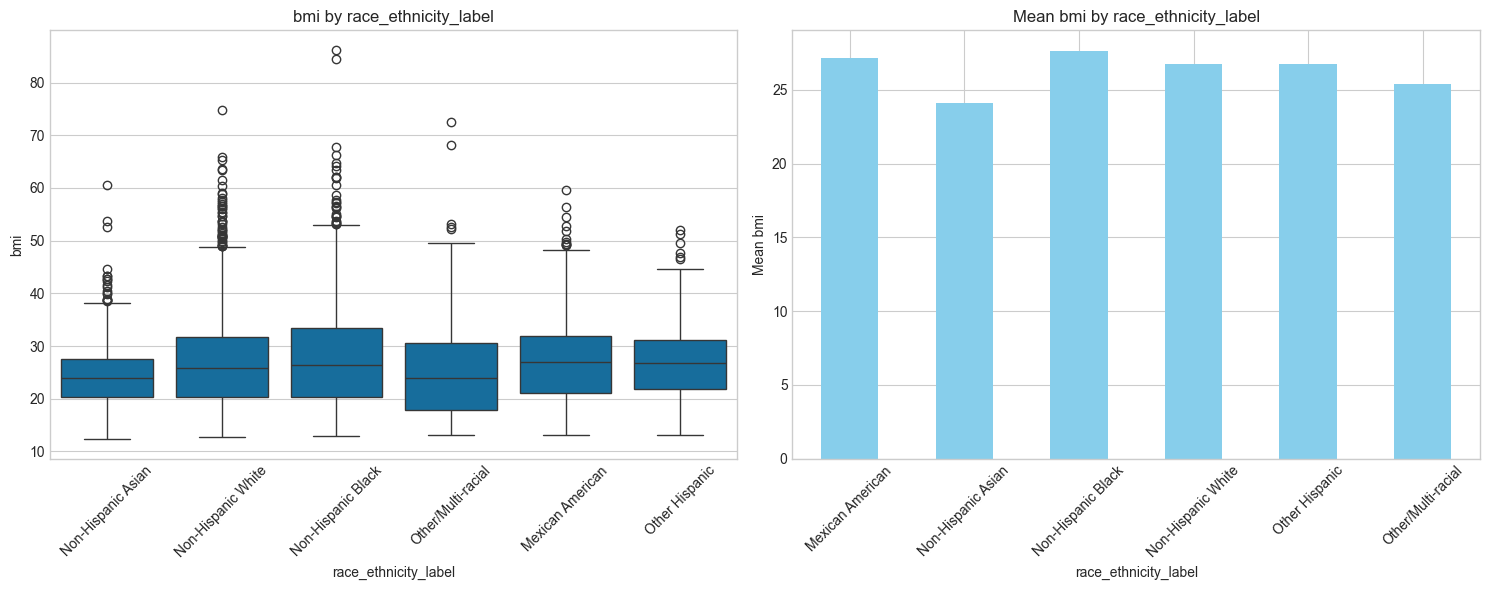

In [44]:
# Visualize BMI by race/ethnicity
if 'bmi' in merged_df.columns and 'race_ethnicity_label' in merged_df.columns:
    explorer.create_demographic_visualization(merged_df, 'bmi', 'race_ethnicity_label')

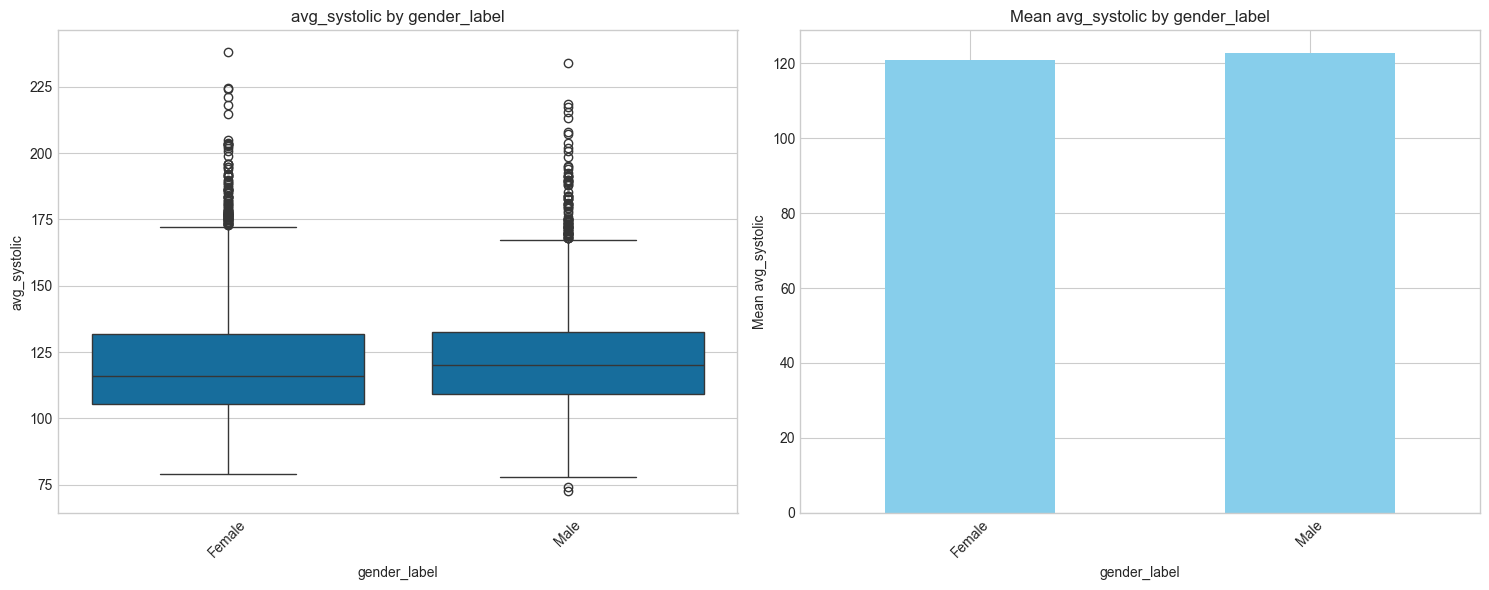

In [45]:
# Visualize blood pressure by gender
if 'avg_systolic' in merged_df.columns and 'gender_label' in merged_df.columns:
    explorer.create_demographic_visualization(merged_df, 'avg_systolic', 'gender_label')

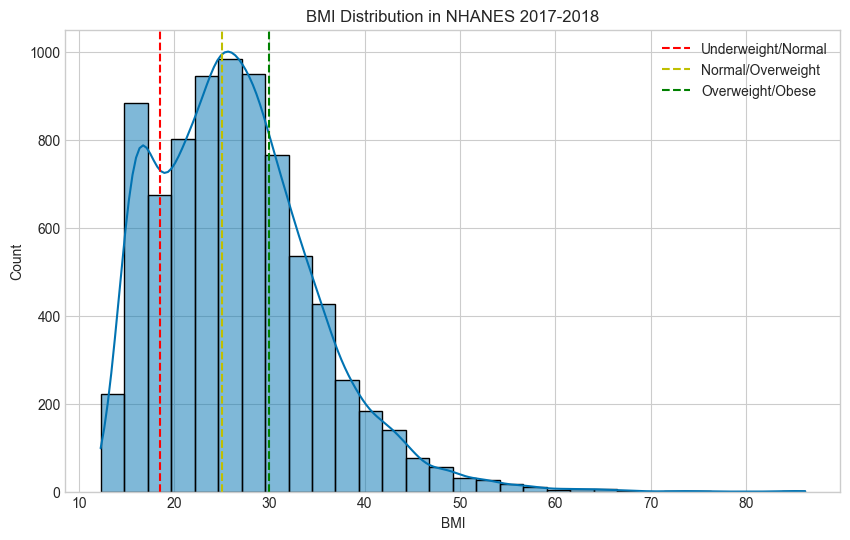

In [46]:
# Visualize BMI distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['bmi'].dropna(), bins=30, kde=True)
plt.axvline(x=18.5, color='r', linestyle='--', label='Underweight/Normal')
plt.axvline(x=25, color='y', linestyle='--', label='Normal/Overweight')
plt.axvline(x=30, color='g', linestyle='--', label='Overweight/Obese')
plt.title('BMI Distribution in NHANES 2017-2018')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

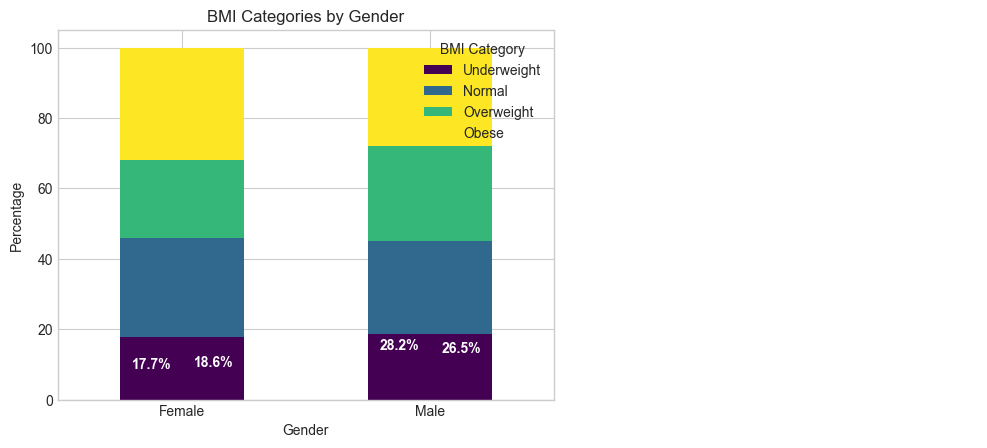

In [47]:
# Visualize BMI categories by gender
if 'bmi_category' in merged_df.columns and 'gender_label' in merged_df.columns:
    # Create a cross-tabulation
    bmi_gender_crosstab = pd.crosstab(
        merged_df['gender_label'], 
        merged_df['bmi_category'], 
        normalize='index'
    ) * 100
    
    # Plot
    plt.figure(figsize=(12, 6))
    bmi_gender_crosstab.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('BMI Categories by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Percentage')
    plt.legend(title='BMI Category')
    plt.xticks(rotation=0)
    for i, v in enumerate(bmi_gender_crosstab.iloc[0]):
        plt.text(i-0.2, v/2, f"{v:.1f}%", color='white', fontweight='bold')
    for i, v in enumerate(bmi_gender_crosstab.iloc[1]):
        plt.text(i+0.05, v/2, f"{v:.1f}%", color='white', fontweight='bold')
    plt.show()

## 7. Interactive Dashboard

Let's create a simple interactive dashboard to explore the data.

In [48]:
# Define a function to create an interactive visualization
def interactive_analysis(metric, demographic, df=merged_df):
    if metric not in df.columns or demographic not in df.columns:
        print(f"Column {metric} or {demographic} not found in dataset")
        return
    
    # Remove missing values
    plot_df = df[[demographic, metric]].dropna()
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot
    sns.boxplot(data=plot_df, x=demographic, y=metric, ax=axes[0])
    axes[0].set_title(f'{metric} by {demographic}')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Bar plot of means
    means = plot_df.groupby(demographic)[metric].mean().sort_values(ascending=False)
    means.plot(kind='bar', ax=axes[1], color='skyblue')
    axes[1].set_title(f'Mean {metric} by {demographic}')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylabel(f'Mean {metric}')
    
    # Add value labels to the bar plot
    for i, v in enumerate(means):
        axes[1].text(i, v + 0.1, f"{v:.1f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics
    stats = plot_df.groupby(demographic)[metric].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    stats.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
    return stats

# Create dropdown menus for metrics and demographics
numeric_metrics = ['age_years', 'bmi', 'weight_kg', 'height_cm', 'waist_cm', 'avg_systolic', 'avg_diastolic']
available_metrics = [m for m in numeric_metrics if m in merged_df.columns]

demographics = ['gender_label', 'race_ethnicity_label']
available_demographics = [d for d in demographics if d in merged_df.columns]

# Create interactive widget
interact(
    interactive_analysis,
    metric=widgets.Dropdown(options=available_metrics, description='Metric:'),
    demographic=widgets.Dropdown(options=available_demographics, description='Demographic:'),
    df=fixed(merged_df)
);

interactive(children=(Dropdown(description='Metric:', options=('age_years', 'bmi', 'weight_kg', 'height_cm', '…

## 8. Example Analyses

Let's perform some more specific analyses on the data.

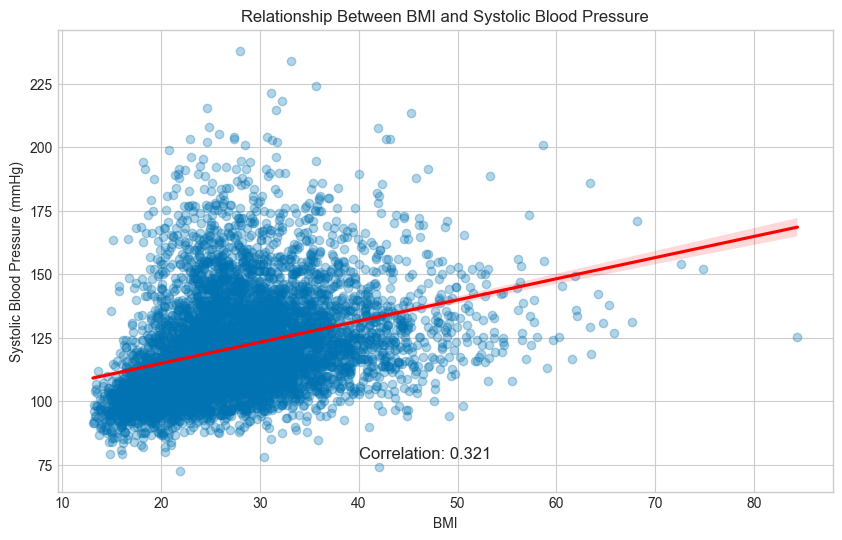


Blood Pressure Statistics by BMI Category:


,Count,Mean,Median,Std Dev,Min,Max
bmi_category,,,,,,
Underweight,549,103.53,102.00,13.20,79.00,194.00
Normal,1956,116.84,112.67,19.37,72.67,215.33
Overweight,1840,124.26,120.67,19.72,87.33,238.00
Obese,2292,127.65,124.67,19.04,74.00,234.00


In [49]:
# Analyze relationship between BMI and blood pressure
if all(col in merged_df.columns for col in ['bmi', 'avg_systolic', 'avg_diastolic']):
    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(data=merged_df, x='bmi', y='avg_systolic', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Relationship Between BMI and Systolic Blood Pressure')
    plt.xlabel('BMI')
    plt.ylabel('Systolic Blood Pressure (mmHg)')
    
    # Calculate and display correlation coefficient
    correlation = merged_df[['bmi', 'avg_systolic']].corr().iloc[0, 1]
    plt.text(40, merged_df['avg_systolic'].min() + 5, f"Correlation: {correlation:.3f}", fontsize=12)
    plt.show()
    
    # Calculate summary statistics by BMI category
    if 'bmi_category' in merged_df.columns:
        bp_by_bmi_category = explorer.analyze_by_demographics(merged_df, 'avg_systolic', 'bmi_category')
        print("\nBlood Pressure Statistics by BMI Category:")
        display(bp_by_bmi_category)

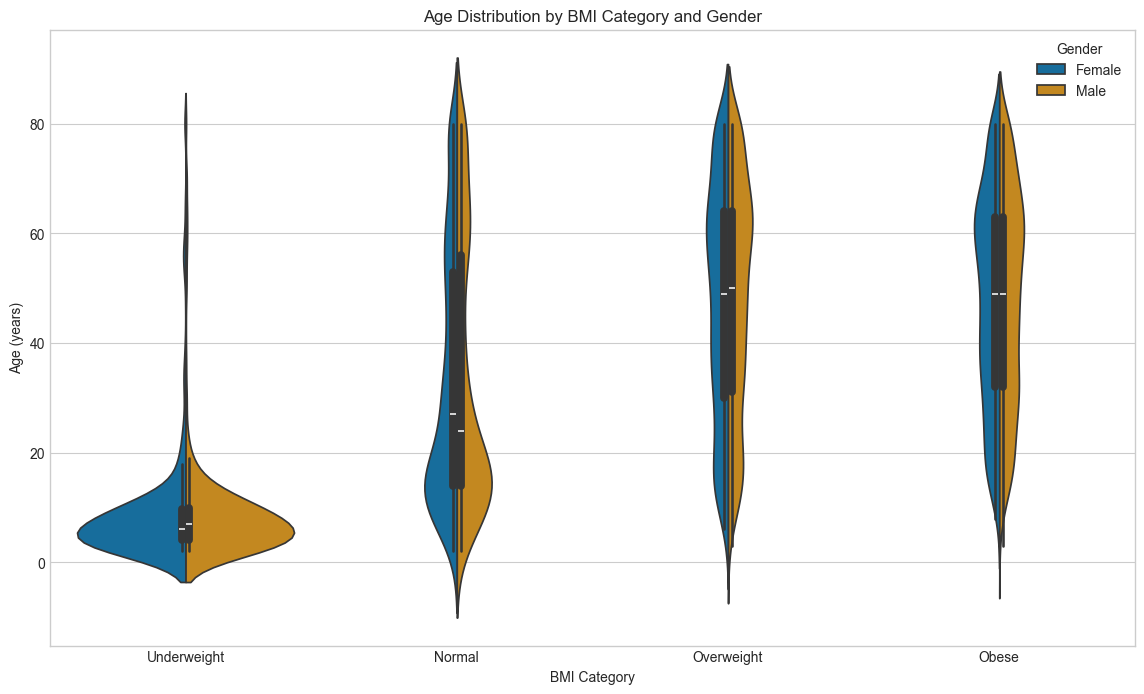

In [50]:
# Analyze age distribution by gender and BMI category
if all(col in merged_df.columns for col in ['age_years', 'gender_label', 'bmi_category']):
    plt.figure(figsize=(14, 8))
    sns.violinplot(data=merged_df, x='bmi_category', y='age_years', hue='gender_label', split=True)
    plt.title('Age Distribution by BMI Category and Gender')
    plt.xlabel('BMI Category')
    plt.ylabel('Age (years)')
    plt.legend(title='Gender')
    plt.show()

## 9. Multi-cycle Analysis

Let's compare some metrics across multiple NHANES cycles.

Processing cycle 2021-2022...
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BMX_L.xpt
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BMX_L.xpt
Processing cycle 2019-2020...
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2019/DataFiles/BMX_K.xpt
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/BMX_K.XPT
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/BMX_K.XPT
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/BMX_K.xpt
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/BMX_K.xpt
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/bmx_K.XPT
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/bmx_K.XPT
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/bmx_K.xpt
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Nhanes/2019-2020/bmx_K.xpt
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/2019-2020/BMX_K.

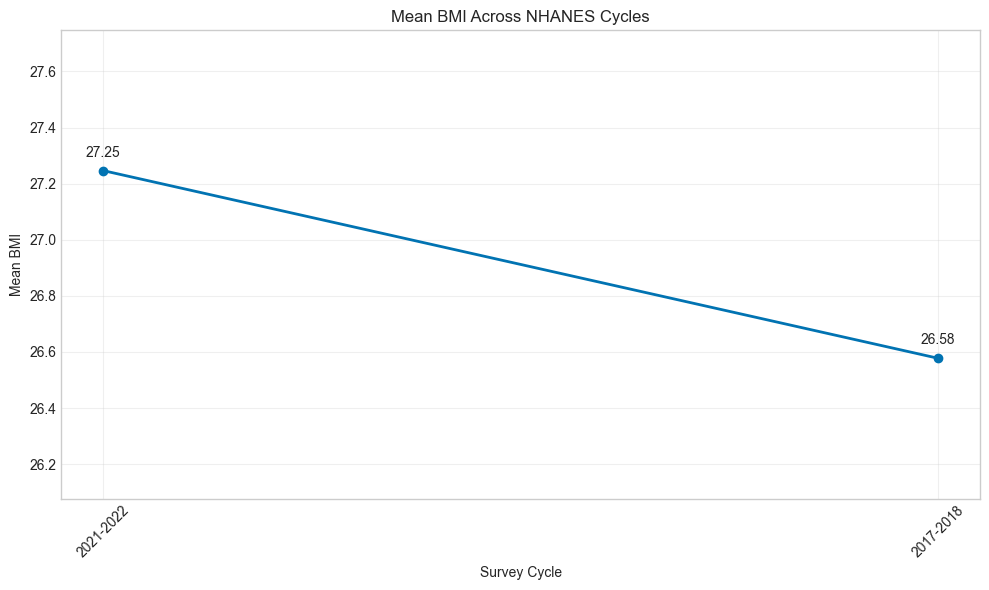

In [51]:
# Function to get mean BMI across multiple cycles
def get_mean_bmi_by_cycle(cycles):
    results = []
    for cycle in cycles:
        print(f"Processing cycle {cycle}...")
        # Get body measurements data for this cycle
        body_df = explorer.get_body_measures(cycle)
        if not body_df.empty and 'bmi' in body_df.columns:
            mean_bmi = body_df['bmi'].mean()
            results.append({'cycle': cycle, 'mean_bmi': mean_bmi})
    return pd.DataFrame(results)

# Get BMI trends across the last 3 cycles
cycles_to_analyze = explorer.available_cycles[:3]  # Most recent 3 cycles
bmi_trends = get_mean_bmi_by_cycle(cycles_to_analyze)

# Plot BMI trends
if not bmi_trends.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(bmi_trends['cycle'], bmi_trends['mean_bmi'], marker='o', linestyle='-', linewidth=2)
    plt.title('Mean BMI Across NHANES Cycles')
    plt.xlabel('Survey Cycle')
    plt.ylabel('Mean BMI')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add value labels
    for i, row in bmi_trends.iterrows():
        plt.text(i, row['mean_bmi'] + 0.05, f"{row['mean_bmi']:.2f}", ha='center')
    
    # Set y-axis to start from a reasonable value for better visualization
    plt.ylim(bottom=bmi_trends['mean_bmi'].min() - 0.5, top=bmi_trends['mean_bmi'].max() + 0.5)
    
    plt.tight_layout()
    plt.show()

## 10. Geographical Analysis

Note: NHANES doesn't provide detailed geographic data below the national level in public datasets to protect participant confidentiality. However, we can demonstrate how you might analyze such data if it were available.

In [55]:
# Simulated geographic analysis using plotly
# (Note: This uses simulated data since NHANES doesn't provide detailed geographic information)

# Create simulated data - obesity rates by state
import random
from urllib.request import urlopen
import json

# Try to load US states geojson for mapping
try:
    # Load state-level GeoJSON (not county-level)
    with urlopen('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json') as response:
        states_geojson = json.load(response)
    
    # Simulate state-level obesity data
    state_fips = pd.read_csv('https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_fips_master.csv')
    
    # Generate random obesity rates (simulated data)
    np.random.seed(42)  # For reproducibility
    state_fips['obesity_rate'] = np.random.normal(loc=30, scale=5, size=len(state_fips))
    state_fips['obesity_rate'] = state_fips['obesity_rate'].clip(lower=20, upper=40).round(1)
    
    # Create choropleth map using state abbreviations
    fig = px.choropleth(
        state_fips,
        geojson=states_geojson,
        locations='state_abbr',  # Use state abbreviation
        locationmode='USA-states',  # Tell plotly we're using US state codes
        color='obesity_rate',
        color_continuous_scale='YlOrRd',
        range_color=(20, 40),
        scope="usa",
        labels={'obesity_rate':'Obesity Rate (%)'},
        title="Simulated Obesity Rates by State (For Demonstration Only)",
        hover_data=['state_name']  # Show state name on hover
    )
    fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0}, height=600)
    fig.show()
    
    print("NOTE: The map above uses simulated data for demonstration purposes only. ")
    print("NHANES does not provide public state-level estimates due to confidentiality constraints.")
    print("For actual state-level estimates, consider using BRFSS data from the CDC.")
    
except Exception as e:
    print(f"Could not create geographic visualization: {str(e)}")
    print("Note: This requires an internet connection to fetch the GeoJSON data.")


Could not create geographic visualization: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Note: This requires an internet connection to fetch the GeoJSON data.


## 11. Conclusion

In this notebook, we've demonstrated how to use the NHANESExplorer class to download, process, and analyze NHANES data. We've explored various health metrics across demographic groups and created visualizations to better understand the data.

The NHANESExplorer provides a convenient way to work with NHANES data and can be extended to support additional analyses and visualizations. For real geographic analyses, consider using complementary datasets like BRFSS (Behavioral Risk Factor Surveillance System) which provides state-level estimates.

## Next Steps

1. Explore additional NHANES components like dietary intake or physical activity
2. Develop more sophisticated statistical analyses
3. Create custom visualizations for specific research questions
4. Implement machine learning models to predict health outcomes based on NHANES variables